In [1]:
from travelAndMutate.randominterface import NumpyRandomGenerator
from travelAndMutate.system import System

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from time import time
from scipy.optimize import root_scalar

In [3]:
rng = NumpyRandomGenerator()

In [4]:
def kernel(rng, tmax, params_df, commuting_mat):
    sys = System(rng.cpprng, commuting_mat, 1)
    for i in range(params_df.shape[0]):
        sys.setPatchProperties(i, params_df["N"][i], params_df["beta"][i], params_df["epsilon"][i], params_df["mu"][i])
    sys.seedEpidemic(params_df["I0"].tolist())
    sys.spreadForTime(tmax)
    return [pd.DataFrame.from_records(sys.getFullTrajectory(p), index="t") / params["N"][p] for p in range(params_df.shape[0])]

In [5]:
def Rinf_equation(Rinf, R0, s0):
    return 1 - Rinf - s0 * np.exp(-Rinf*R0)

In [6]:
Npatch = 4

,0,1,2,3,4
0,1,0,0,0,0
1,0,1,0,0,0
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,0,1


,N,beta,epsilon,mu,I0,R0
Patch,,,,,,
0,1000000,0.6,0.1,0.3,1000000,2.0
1,1000000,0.6,0.1,0.3,1000000,2.0
2,1000000,0.6,0.1,0.3,1000000,2.0
3,1000000,0.6,0.1,0.3,1000000,2.0
4,1000000,0.6,0.1,0.3,1000000,2.0


Duration per replica: 0.01 sec


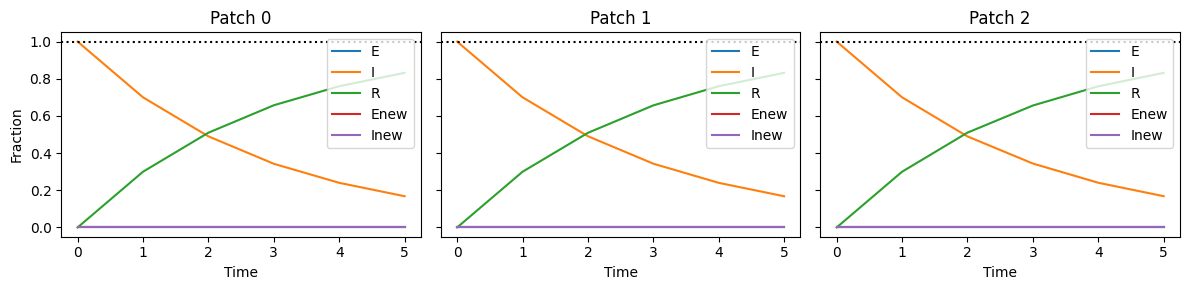

In [40]:
start = time()

commuting = np.where(np.eye(Npatch).astype(bool), 1, 0)# rng.rng.random(size=(Npatch,Npatch))/Npatch**2)
display(pd.DataFrame(commuting))

tmax = 5

params = pd.DataFrame()
params["N"] = np.full(Npatch, 1e6, dtype=int)
params["beta"] = np.full(Npatch, 0.6)# + rng.rng.normal(scale=0.01, size=Npatch)
params["epsilon"] = np.full(Npatch, 0.1)# + rng.rng.normal(scale=0.005, size=Npatch)
params["mu"] = np.full(Npatch, 0.3)# + rng.rng.normal(scale=0.005, size=Npatch)
#params["I0"] = np.full(Npatch, 10)
params["I0"] = params["N"]
params["R0"] = (params["beta"] / params["mu"]) @ commuting
params.index.name = "Patch"
display(params)

reps = 5
for i in range(reps):
    result = kernel(rng, tmax, params, commuting)

end = time()
print(f"Duration per replica: {np.round((end-start)/5, 2)} sec")

fig, axs = plt.subplots(1,3,figsize=(12,3),sharey=True)
for i in range(min(Npatch,len(axs))):
    result[i].drop("S", axis=1).plot(ax=axs[i])
    axs[i].set_title(f"Patch {i}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Fraction")
    Rinf = root_scalar(Rinf_equation, args=(params["R0"][i],1-params["I0"][i]/params["N"][i]), x0=params["R0"][i]).root
    #axs[i].axhline(Rinf, color="k", linestyle=":")
    axs[i].axhline(params["I0"][i]/params["N"][i], color="k", linestyle=":")
fig.tight_layout()

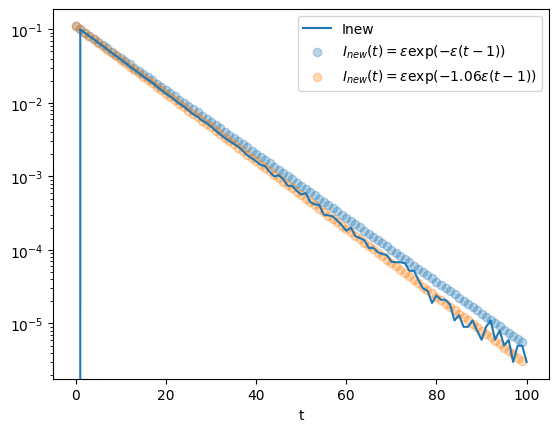

In [21]:
(result[2]["Inew"]).plot()
xs = np.arange(100)
epsilon = params["epsilon"][0]
corr = (1+0.06)
plt.scatter(xs, epsilon*np.exp(-(xs-1)*epsilon), marker="o", alpha=0.3, label=r"$I_{new}(t) = \varepsilon \exp(-\varepsilon(t-1))$")
plt.scatter(xs, epsilon*np.exp(-(xs-1)*epsilon*corr), marker="o", alpha=0.3, label=r"$I_{new}(t) = \varepsilon \exp(-$"+str(corr)+r"$\varepsilon(t-1))$")
plt.legend()
plt.yscale("log")
#plt.xlim([0,5])
#plt.ylim([0,50])

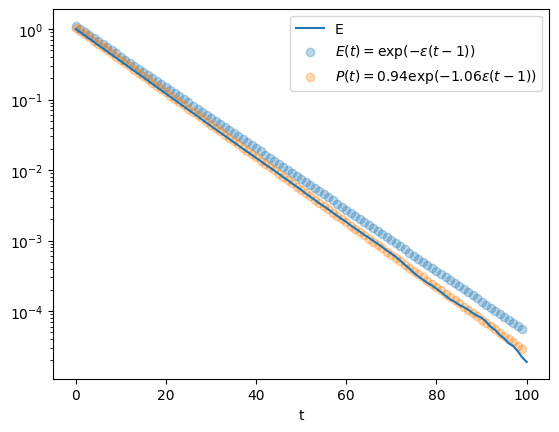

In [20]:
(result[2]["E"]).plot()
xs = np.arange(100)
epsilon = params["epsilon"][0]
corr = (1+0.06)
plt.scatter(xs, np.exp(-(xs-1)*epsilon), marker="o", alpha=0.3, label=r"$E(t) = \exp(-\varepsilon(t-1))$")
plt.scatter(xs, 1/corr*np.exp(-(xs-1)*epsilon*corr), marker="o", alpha=0.3, label=r"$E(t) = $"+str(round(1/corr,2))+"$ \exp(-$"+str(corr)+r"$\varepsilon(t-1))$")
plt.legend()
plt.yscale("log")
#plt.xlim([0,5])
#plt.ylim([0,50])

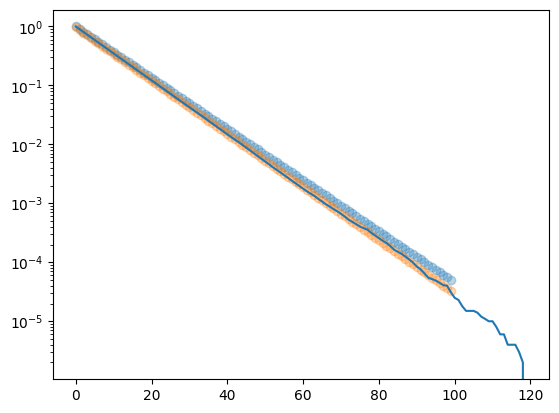

In [58]:
plt.plot(Es)
xs = np.arange(100)
corr = (1+0.04)
plt.scatter(xs, 1/np.exp(eps)*np.exp(-(xs-1)*eps), marker="o", alpha=0.3, label=r"$I_{new}(t) = \varepsilon \exp(-\varepsilon(t-1))$")
plt.scatter(xs, 1/np.exp(eps)/corr*np.exp(-(xs-1)*eps*corr), marker="o", alpha=0.3, label=r"$I_{new}(t) = \varepsilon \exp(-$"+str(corr)+r"$\varepsilon(t-1))$")
plt.yscale("log")

,0,1,2
0,1,0,0
1,0,1,0
2,0,0,1


,N,beta,epsilon,mu,I0,R0
Patch,,,,,,
0,1000000,0.06,0.1,0.03,2,2.0
1,1000000,0.06,0.1,0.03,2,2.0
2,1000000,0.06,0.1,0.03,2,2.0


Duration per replica: 0.03 sec

Measured survived 0.7633333333333333, expected 0.75


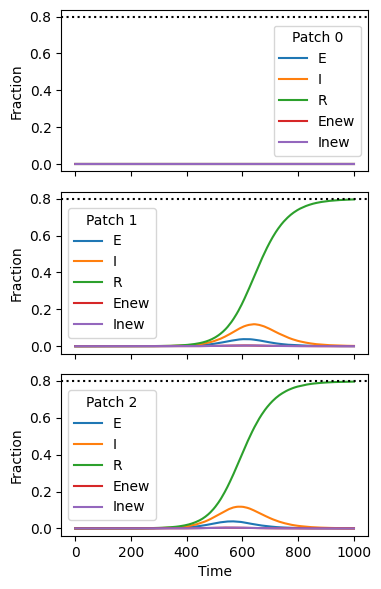

In [19]:
start = time()

Npatch = 3

commuting = np.where(np.eye(Npatch).astype(bool), 1, 0)# rng.rng.random(size=(Npatch,Npatch))/Npatch**2)
display(pd.DataFrame(commuting))

tmax = 1000

params = pd.DataFrame()
params["N"] = np.full(Npatch, 1e6, dtype=int)
params["beta"] = np.full(Npatch, 0.06)# + rng.rng.normal(scale=0.01, size=Npatch)
params["epsilon"] = np.full(Npatch, 0.1)# + rng.rng.normal(scale=0.005, size=Npatch)
params["mu"] = np.full(Npatch, 0.03)# + rng.rng.normal(scale=0.005, size=Npatch)
params["I0"] = np.full(Npatch, 2)
params["R0"] = (params["beta"] / params["mu"]) @ commuting
params.index.name = "Patch"
display(params)

reps = 100
avgs = []
for i in range(reps):
	result = kernel(rng, tmax, params, commuting)
	avgs.append([r["R"].iloc[-1] for r in result])
avgs = np.array(avgs)

end = time()
print(f"Duration per replica: {np.round((end-start)/reps, 2)} sec")

print()
print(f"Measured survived {np.sum(avgs > 0.2)/reps/Npatch}, expected {1-(1-1/params['R0'][0])**params['I0'][0]}")

fig, axs = plt.subplots(3,1,figsize=(4,6),sharex=True)
for i in range(min(Npatch,len(axs))):
	result[i].drop("S", axis=1).plot(ax=axs[i])
	axs[i].set_xlabel("Time")
	axs[i].set_ylabel("Fraction")
	Rinf = root_scalar(Rinf_equation, args=(params["R0"][i],1-params["I0"][i]/params["N"][i]), x0=params["R0"][i]).root
	axs[i].axhline(Rinf, color="k", linestyle=":")
	axs[i].legend(title=f"Patch {i}")
fig.tight_layout()

(array([[ 26.,   0.,   0.,   0.,   0.,   0.,   0.,  74.,   0.,   0.],
        [ 50.,   0.,   0.,   0.,   0.,   1.,   0., 149.,   0.,   0.],
        [ 71.,   0.,   0.,   0.,   0.,   1.,   1., 227.,   0.,   0.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 3 BarContainer objects>)

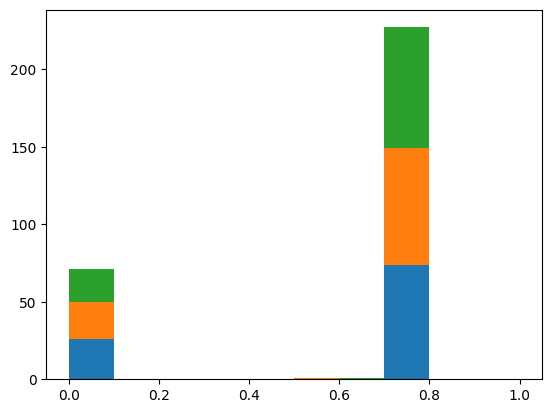

In [20]:
plt.hist(avgs, bins=np.linspace(0,1,11), stacked=True)